# Looking for Summer Shade
> "This blog post walks through how to deal with Bigquery GIS data by looking for regions in New York City with the most shade."

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- hide: false
- search_exclude: true

Bigquery has a lot of public datasets available.
Not only is there a vast number of datasets available,
but cross referencing them and accessing them is free (up 
until a limit)!

The purpose of this blog post is show how easy this is.
In this blog post, I will walk you through the New York tree dataset
and the US Census zip code geometry dataset to show you how to 
compute how likely a region is to have shade, making it a nicer 
candidate for a stroll on a hot summer day.

# Part I: Getting the data in bigquery

Getting the data is fairly easy. Google has documentation [here](https://cloud.google.com/bigquery/docs/quickstarts/quickstart-web-ui).
It is assumed that you have already created a google cloud account.
But if you did not, I hope this motivates you to give it a try!

## The datasets
For this demo, I will be looking at two datasets:

### New York street trees
We will be looking at data gathered from the 2015 tree census.
You may find it [here](https://console.cloud.google.com/marketplace/product/city-of-new-york/nyc-tree-census)

### US Census Boundaries
When looking at the data, we will segment it by some sort of boundary for easier visualization.
We could use tiling approaches, but it will be fun to use existing data. 
Let's try the zip code 
[tabulation areas](https://www.census.gov/programs-surveys/geography/guidance/geo-areas/zctas.html).
You may find the us census boundaries dataset
[here](https://console.cloud.google.com/marketplace/product/united-states-census-bureau/us-geographic-boundaries)

## Bigquery: The pandas API
These datasets are actually pretty small to download and work with offline.
But since this data is offered publicly in bigquery, and bigquery offers up to 
2TB of queries free per month (here we'll be running about 12 GB of queries),
it is well worth leveraging. On top of this, some of the queries we need to make
will involve geospatial joins. It will be much easier to let bigquery handle this.

The queries that will be presented could just be run in the UI [here](https://console.cloud.google.com/bigquery). However, for convenience,
they will be run in a jupyter notebook.

## Setup: Import packages and extensions
We'll be using a few packages along the way.
I'll leave comments for what each is for.

In [1]:
# For creating geojson files for plotting
import geojson
# For plotting
import plotly.express as px
# For filtering some of the tabular data we will generate
import pandas as pd
# For converting shapes
import shapely
# For converting shape information output as text from bigquery
import shapely.wkt

# Used to send bigquery queries.
%load_ext google.cloud.bigquery

## Query bigquery for relevant zip codes
We will be using zip codes to visualize boundaries.

Here is the query:

In [2]:
%%bigquery df_zip_codes --use_bqstorage_api

WITH 
zip_codes AS (
    SELECT 
        # The zip code
        zip_code,
        # The place name (mainly useful for plotting)
        city,
        # The boundary of the zip code (for plotting)
        zip_code_geom ,
        # Some internal point in the zip code
        internal_point_geom, 
        # We compute the surface aread of a zip code. We will need this later.
        ST_AREA(zip_code_geom) * 1e-6 AS surface_area_km2
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    # We filter only for new york zip codes
    WHERE state_code = 'NY'
),
# The last two temporary tables are used to further filter down our zip
# codes. These last two are not necessary and can be ignore as we will be 
# filtering the data at a further step. However, it helps to perform filtering
# like this earlier on if possible when we're certain that we won't need the data.
new_york_area AS (
    SELECT * FROM `bigquery-public-data.geo_us_boundaries.urban_areas`
    WHERE REGEXP_CONTAINS(LOWER(name), '.*new york.*')
),
new_york_zip_codes AS (
    SELECT 
        zip_code,
        city,
        zip_code_geom,
        surface_area_km2
    FROM zip_codes AS z
    JOIN new_york_area AS n
    ON ST_CONTAINS(n.urban_area_geom, z.internal_point_geom)
)


# I like to keep my final query simple. Sometimes
# queries can grow, and factoring queries into temporary
# tables helps better manage them.
SELECT * FROM new_york_zip_codes

Downloading: 100%|██████████| 441/441 [00:02<00:00, 193.66rows/s]


We now have all new york zip codes. 

In [3]:
df_zip_codes

,zip_code,city,zip_code_geom,surface_area_km2
0,11955,"Center Moriches CDP, Moriches CDP, Manorville CDP","POLYGON((-72.839904 40.818861, -72.839687 40.8...",8.010525
1,11789,"Sound Beach CDP, Rocky Point CDP","POLYGON((-72.987006 40.955116, -72.986997 40.9...",6.782860
2,11717,"Central Islip CDP, North Bay Shore CDP, Brentw...","POLYGON((-73.295162 40.769269, -73.295162 40.7...",28.214786
3,11755,"Lake Grove village, St. James CDP, Lake Ronkon...","POLYGON((-73.136194 40.865864, -73.136146 40.8...",8.399816
4,11946,"Flanders CDP, Shinnecock Hills CDP, Hampton Ba...","MULTIPOLYGON(((-72.540743 40.815076, -72.54076...",40.879001
...,...,...,...,...
436,10601,White Plains city,"POLYGON((-73.776398 41.032189, -73.776393 41.0...",1.640223
437,10706,"Yonkers city, Hastings-on-Hudson village","POLYGON((-73.888685 40.976827, -73.888824 40.9...",7.485093
438,10701,"Yonkers city, Hastings-on-Hudson village","MULTIPOLYGON(((-73.908934 40.91852, -73.908942...",10.967166
439,10580,"Mamaroneck village, Rye city, Harrison village","MULTIPOLYGON(((-73.696873 40.951398, -73.69647...",23.010001


### Aside: Vizualizing using GeoViz
Note that when exploring this data, you can leverage a free visualization tool
in bigquery called geoviz. For example, you can run this query to select all new 
york zip codes:
<img src="images/2021-05-30-click-geoviz-example.png" alt="BigQuery UI" width=600>


and click "Explore with GeoViz" to explore it:
<img src="images/2021-05-30-geoviz-example.png" alt="BigQuery UI" width=600>

The purpose of this blog is not to go through these details but I thought
I would highlight this useful feature.

### The bigquery query for trees
We will not query the new york trees census.

Since our goal is to understand how each zip code is doing, we will also join
it will information from the same zip codes table we used previously.

I will present the query involved here and explain it afterwards.
Don't worry if some pieces don't seem to make sense yet.

In [4]:
%%bigquery df_trees --use_bqstorage_api

# This is the tree table. We generate it from the 2015 tree 
# census and join it with the tree species table to join additional
# inforamtio
WITH trees AS (
SELECT 
    ts.species_common_name,
    ST_GEOGPOINT(tc.longitude, tc.latitude) as center,  
    FROM `bigquery-public-data.new_york_trees.tree_census_2015` as tc 
    LEFT JOIN `bigquery-public-data`.new_york.tree_species as ts
    ON LOWER(tc.spc_common) = LOWER(ts.species_common_name)
    WHERE tc.status = 'Alive'
    AND STARTS_WITH(ts.tree_size, 'Large')
),
# For zip codes, we only need the zip code and boundaries
zip_codes AS (
    SELECT zip_code, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
)

# We perform a spatial join. 
# For every tree that is in a zip code, we will create one row
# with the zip code and tree information.
SELECT z.zip_code, t.* FROM trees AS t
JOIN zip_codes AS z
ON ST_CONTAINS(z.zip_code_geom, t.center)

Downloading: 100%|██████████| 275822/275822 [00:02<00:00, 115375.49rows/s]


### What just happened here?
There are a few things going on in this query which I have not explained.
I will now explain them in detail.

We know we want the geographical distribution of trees, so we have to include
this in our query to start:

```sql
SELECT 
    ST_GEOGPOINT(tc.longitude, tc.latitude) as center,  
    FROM `bigquery-public-data.new_york_trees.tree_census_2015` as tc 
    WHERE tc.status = 'Alive'
```

Here, `status` is an indicator of the tree health and `center` is it's location
as a `GEOGRAPHY` data type (this is the general umbrella data type for any
geospatial related data. See [here](https://cloud.google.com/bigquery/docs/reference/standard-sql/geography_functions) for documentation).
Because this dataset includes dead trees, and we only care about shade, we use the `status` 
field to filter down this dataset to live trees.


Since we want to know how much shade a region will be, we need to know a bit more
about the trees. The tree census table does not contain much information about 
the trees themselves. However, there is another table, `tree_species` which does.
We can use the `tree_size` property to tell us how big a tree is. If you explore
the possible values, you will see that the posible values are:

In [5]:
%%bigquery df_tree_sizes --use_bqstorage_api

SELECT tree_size, COUNT(*) AS count
FROM `bigquery-public-data`.new_york.tree_species 
GROUP BY tree_size

Downloading: 100%|██████████| 4/4 [00:01<00:00,  2.64rows/s]


In [6]:
df_tree_sizes

,tree_size,count
0,Large (Mature Height > 50 ft),23
1,Small (Mature Height < 25 ft),18
2,Medium (Mature Height 35-50 ft),11
3,Intermediate (Mature Height 25-35 ft),5


We have 23 tree species that are Large, 11 Medium, 5 intermediate and 18 that are small.
Since we really care about shade, and generally the largest trees provide the most shade,
let's filter this data set down to the large trees.
We can filter these rows out by just choosing the trees whose size
attribute starts with 'Large'.


### Putting it all together
We have in one table, a list of trees with their locations and in 
another table, a list of tree species we care about.
We can join these two together by the species name.
It turns out that in one table, the name has case whereas the other does not,
so we'll have to process the species name a bit:
```SQL
    SELECT *
    FROM `bigquery-public-data.new_york_trees.tree_census_2015` as tc 
    LEFT JOIN `bigquery-public-data`.new_york.tree_species as ts
    ON LOWER(tc.spc_common) = LOWER(ts.species_common_name)
```
The `FROM` line contains the tree census table (which we alias to `tc`).
The `LEFT JOIN` line contains the tree species table that we want to join
on (aliased to `ts`) and the `ON` line contains the condition we want
to join on: `LOWER(tc.spc_common) = LOWER(ts.species_common_name)`.
The final query ends up being:


```SQL
SELECT 
    ts.species_common_name,
    ST_GEOGPOINT(tc.longitude, tc.latitude) as center,  
    FROM `bigquery-public-data.new_york_trees.tree_census_2015` as tc 
    LEFT JOIN `bigquery-public-data`.new_york.tree_species as ts
    ON LOWER(tc.spc_common) = LOWER(ts.species_common_name)
    WHERE tc.status = 'Alive'
    AND STARTS_WITH(ts.tree_size, 'Large')
)
```


Finally, we join this data with zip code data so that we can tag
a zip code to the trees, again through a geospatial join:
```SQL
    SELECT z.zip_code, t.* FROM trees AS t
    JOIN zip_codes AS z
    ON ST_CONTAINS(z.zip_code_geom, t.center)
```

and we're done!


How many trees do we end up with?
We get 275822. New York has quite a few trees:

In [7]:
df_trees

,zip_code,species_common_name,center
0,11106,Shingle Oak,POINT(-73.92839366 40.76088873)
1,11428,White Ash,POINT(-73.752901 40.71995185)
2,10452,White Ash,POINT(-73.92219751 40.83795482)
3,11413,Shingle Oak,POINT(-73.75865478 40.66516833)
4,11209,White Ash,POINT(-74.04092309 40.62347333)
...,...,...,...
275817,10461,Littleleaf Linden,POINT(-73.85256967 40.84603874)
275818,10461,Littleleaf Linden,POINT(-73.85053657 40.85204694)
275819,10461,Littleleaf Linden,POINT(-73.84115012 40.8568)
275820,10461,Littleleaf Linden,POINT(-73.83248666 40.84078862)


# Part 3: Computing the shadiness per zip code
Finally, we are interested in the shadiness of a zip code.
How will we determine this?

We can calculate it by just taking the number of trees in a given
zip code and divide it by the surface area of the zip code.
We'll do this bit in python, although it would certainly have been
just as easy to run it in bigquery:

In [8]:
# We create a temporary table with the columns 'zip_code' and 'count'
# where the 'count' colum is 1 for all rows
df_t = df_trees[['zip_code']].assign(count = 1)
# We now sum count for each zip code. This gives us the number
# of trees per zip code.
df_per_zip = df_t.groupby('zip_code').sum().reset_index(drop=False)
# Finally, we need the surface area. We get it by joining the
# zip codes table we created earlier:
df_per_zip = pd.merge(
    df_per_zip, 
    df_zip_codes[['zip_code', 'surface_area_km2']],
    on='zip_code',
    how='left'
)
# And finally, we compute the count per km^2
df_per_zip['count_per_km2'] = df_per_zip['count'] / df_per_zip['surface_area_km2']

# Part 4: Vizualization

We now want to visualize this data somehow. 
We're going to make a choropleth plot using
[plotly](https://plotly.com/python/choropleth-maps/).
If you haven't heard of it, plotly is an amazing interactive
visualization library using javascript. It is extremely easy to
use and generates professional looking interative graphs
that can be used to give a little more life to your presentations.


## Exploring the zip code shapes
First, let's explore the zip code shapes. Our zip codes table actually contains
the bounding boxes of our zip codes in well known text (WKT) format.

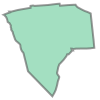

In [9]:
# Test converting one zip code to a shape
# Let's graph one row
row = df_zip_codes.iloc[0]
geom_wkt = row['zip_code_geom']
geom_shapely = shapely.wkt.loads(geom_wkt)
# just print the geometry
geom_shapely

Wow, by simply typing the shapely object we were able to visualize it.
How was this done? It's actually quite simple. The object is converted to 
SVG. You may read about it [here](https://stackoverflow.com/questions/53323459/ipython-shell-and-displaying-charts).

This mostly comes from the fact that jupyter notebooks are run in a browser 
(and this blog is generated from a jupyter notebook). This avoids the need
for libraries like matplotlib 
(see [here](https://ryxcommar.com/2020/04/11/why-you-hate-matplotlib/) for 
possible reasons not to use it).

### Converting from a shapely geometry to geojson
The next bit is a bit out of scope of the goal of this blog post, 
so I will gloss over it quickly.

We will be plotting the counts per surface area for each zip code.

We will first convert each row in the zip codes table to a shapely
geometry:
```py3
zip_code = row['zip_code']
place_name = row['city']
geom_wkt = row['zip_code_geom']
geom_shapely = shapely.wkt.loads(geom_wkt)
```

and from this, generate a `GeoJSON` `Feature` object:
```py3
polygon = shapely.geometry.mapping(
    geom_shapely
)
properties = {
    'zip_code': zip_code,
    'place_name': place_name
}
feature = dict(geojson.feature.Feature(
    geometry=polygon,
    properties=properties,
    id=self.zip_code,
))
```


However, in order to keep things robust, I will wrap this in a class.
The idea here is that we're encoding some kind of information used to 
render GeoJSON data. When faced with these kind of conversions challenges,
it is usually good practice to create an "adapter" class that every external
type converts to. This is especially useful in geospatial data where
often one might need to convert from WKT to something else etc.

Here is our wrapper class:

In [10]:
from __future__ import annotations
from typing import Dict, List


from geojson.feature import FeatureCollection
import dataclasses
from shapely.geometry import Polygon, MultiPolygon
import geojson


@dataclasses.dataclass
class ZipCodeGeometry:
    zip_code: str
    place_name: str
    boundary: Polygon
        
    @staticmethod
    def dataframe_to_feature_collection(df) -> geojson.feature.FeatureCollection:
        zip_code_geoms = ZipCodeGeometry.from_dataframe(df)
        features = [zip_code_geom.to_geojson_feature()
                    for zip_code_geom in zip_code_geoms]
        return dict(FeatureCollection(features=features))
        
    @staticmethod
    def from_dataframe(df) -> List[ZipCodeGeometry]:
        zip_code_geoms = []
        for _, row in df.iterrows():
            zip_code_geoms.append(ZipCodeGeometry.from_row(row))
        return zip_code_geoms

    @staticmethod
    def from_row(row: Dict) -> ZipCodeGeometry:
        geometries = []
        zip_code = row['zip_code']
        place_name = row['city']
        geom_wkt = row['zip_code_geom']
        geom_shapely = shapely.wkt.loads(geom_wkt)
        
        geometry = ZipCodeGeometry(
                zip_code=zip_code,
                place_name=place_name,
                boundary=geom_shapely,
            )
        return geometry
        
    def to_geojson_feature(self) -> geojson.feature.Feature: 
        polygon = shapely.geometry.mapping(
            self.boundary
        )
        properties = {
            'zip_code': self.zip_code,
            'place_name': self.place_name
                     }
        feature = dict(geojson.feature.Feature(
            geometry=polygon,
            properties=properties,
            id=self.zip_code,
        ))
        feature['geometry'] = dict(feature['geometry'])
        return feature

And the conversion:

In [11]:
zip_code_geojson = ZipCodeGeometry.dataframe_to_feature_collection(df_zip_codes)

We now have everything we need to plot!

## Part 2: plotting with plotly

Plotting with plotly is easy:

```py3
fig = px.choropleth_mapbox(
    df_trees,
    geojson=zip_code_geojson,
    locations='zip_code',
    color_continuous_scale='Viridis',
    range_color=(0, 1300),
    zoom=9,
    center={"lat": 40.78307, "lon": -73.95423},
    labels={'count':'count'}
    )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()
```

Since the plot ends up being quite large to render, I have converted it to a 
jpg image below (and commented out the lines).

Note that had I wanted to display the full interactive plot, I could have used this:
```py3
    from IPython.display import HTML
    HTML(fig.to_html())
```
However, the geojson data involved for the plot ends up taking up a lot
of space (>40MB), and so to avoid this space usage I just output it as an image:

In [12]:
#with open('images/2021_05_30_newyork_trees.jpg', 'wb') as file:
#    file.write(fig.to_image(format='jpg', scale=4))

<img src="images/2021_05_30_newyork_trees.jpg" alt="Tree Coverage of New York" width="600"/>

# Some Observations
It looks like the regions that are the shadiest are closest to 
Central Park (upper left region with the yellow zip code boxes).

## Why are there missing regions?
You'll also notice that some areas appear to be missing.
At first, I thought it was an artifact of plotting.
For example, you can see that central park does not appear to belong to any zip code.
You can check this specific zip code in the census bureau page [here](https://data.census.gov/cedsci/map?q=10128&tid=ACSDP5Y2019.DP05&mode=thematic&vintage=2019&layer=VT_2019_860_00_PY_D1&cid=DP05_0001E).
where you'll see something like this:
<img src="images/2021-05-31-zip-codes-census-example.png" alt="zip code 10128" width=600>
This is the official zip code tabulated area provided by the US census.

Note that this differs from what would see in google maps:
<img src="images/2021-05-31-zip-codes-google-maps-example.png" alt="google maps zip code 10128" width=600>
which is more or less what I would have expected. However, it makes sense
that non-inhabited areas would not be included in zip code tabulated areas.

## Are trees from Central Park being counted in the regions with highest tree per surface area?
Also, coincidentially, the areas that appear to be missing
are central park, which is a host to more than 20,000 trees.
It is then resonable to suspect that perhaps some of the trees being 
counted in these regions were accidentally counted from central park.
Is is possible that this happened somehow?
The best way to check that is to just look at the data.

Let's look at zip code 10128 which is one of these problem regions.

In [17]:
# We select the zip code
df_zc_10128 = df_trees[df_trees['zip_code'] == '10128']
df_zc_10128.loc[:, 'latitude'] = df_zc_10128['center'].apply(lambda c: shapely.wkt.loads(c).y)
df_zc_10128.loc[:, 'longitude'] = df_zc_10128['center'].apply(lambda c: shapely.wkt.loads(c).x)

In [18]:
import plotly.express as px
import os

# I am setting a mapbox token here to allow for street view
px.set_mapbox_access_token(os.environ['MAPBOX_TOKEN'])


fig = px.scatter_mapbox(
    df_zc_10128,
    lat="latitude",
    lon="longitude",    
    zoom=13, center = {"lat": 40.78307, "lon": -73.95423},
    color_continuous_scale=px.colors.cyclical.IceFire, size_max=15)
#fig.show()

Again, I converted the figure to image to save space.
```py3
output_filename = 'images/2021_05_30_zip_code_10128.jpg'
with open(output_filename, 'wb') as file:
    file.write(fig.to_image(format='jpg', scale=4))
```

We get:


<img src="images/2021_05_30_zip_code_10128.jpg" width=600>

As you can see, the trees are legitimate!!!!

# Conclusion

We reached the end. This blog post walked you through how to go from
data to meaningful visualization for a sample data set in bigquery.
In this case, we were curious to find regions that contained the most
large trees, and thus were the most likely to be shaded.
We found that the shadiest region is actually very close to Central
Park (Upper East Side).


# Next Steps
I hope this is motivating enough to start exploring the public
datasets offered in bigquery.
You can find them all [here](https://cloud.google.com/bigquery/public-data).

Also, for visualization, I demonstrated choropleth plots.
It's also possible to visualize using tiling schemes. A very common
one is the hextile, which tends to lead to nice looking visualizations.
See [here](https://plotly.com/python/hexbin-mapbox/) for more details.
I hope to delve into it in more detail in a future post (but it is out 
of scope here for now).

I hope you enjoyed it!